# Traffic Analysis Tempe '2012 - 2020' EDA Process (In Progress)

In [76]:
import pandas as pd
import numpy as np 
import seaborn as sns
import pandasql
import statsmodels.api as sm
from pandasql import sqldf

traffic_dataset = pd.read_csv("/Users/n/Downloads/Tempe_Crash_Data.csv")

traffic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39917 entries, 0 to 39916
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   X                    39779 non-null  float64
 1   Y                    39779 non-null  float64
 2   OBJECTID             39917 non-null  int64  
 3   Incidentid           39917 non-null  int64  
 4   DateTime             39917 non-null  object 
 5   Year                 39917 non-null  int64  
 6   StreetName           39898 non-null  object 
 7   CrossStreet          39876 non-null  object 
 8   Distance             39917 non-null  float64
 9   JunctionRelation     39917 non-null  object 
 10  Totalinjuries        39917 non-null  int64  
 11  Totalfatalities      39917 non-null  int64  
 12  Injuryseverity       39917 non-null  object 
 13  Collisionmanner      39917 non-null  object 
 14  Lightcondition       39917 non-null  object 
 15  Weather              39917 non-null 

<AxesSubplot:>

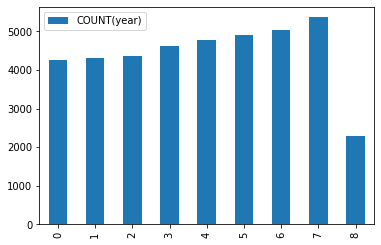

In [77]:
#count of total number of accidents per year fatal + nonfatal
q = """ SELECT Year, COUNT(year)
        FROM traffic_dataset
        GROUP BY Year;
    """

year = sqldf(q, globals())

year.plot.bar(y = 'COUNT(year)')

## Here we are grouping our dataset into blocks one with fatal accidents one with nonfatal accidents


In [78]:
#grouping our dataset into related blocks 
#fatal accidents
q1 = """SELECT * 
        FROM traffic_dataset
        WHERE Totalfatalities > 0;
        """
fatal_frame = sqldf(q1,globals())


q2 = """SELECT * 
        FROM traffic_dataset
            WHERE Totalfatalities = 0"""
nonfatal_frame = sqldf(q2, globals())

## We further break down our data into driver information and time / location information, with our respective nonfatal and fatal blocks


array([[<AxesSubplot:title={'center':'Age_Drv1'}>,
        <AxesSubplot:title={'center':'Age_Drv2'}>]], dtype=object)

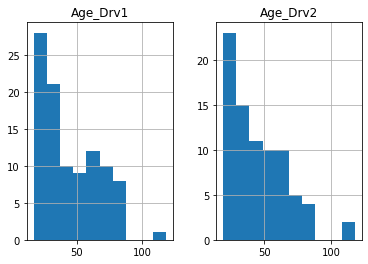

In [79]:
#driver info frame fatal accidents
q3 = """SELECT IncidentID,
        Age_Drv1, Gender_Drv1,Violation1_Drv1, AlcoholUse_Drv1,
        DrugUse_Drv1, Age_Drv2, Gender_Drv2, Violation1_Drv2,
        AlcoholUse_Drv2, DrugUse_Drv2, Totalfatalities, Totalinjuries
        FROM fatal_frame"""

fatal_drv_info = sqldf(q3,globals())

#descriptive stats
fatal_drv_info.describe()

fatal_drv_info.hist(column = ['Age_Drv1', 'Age_Drv2'])

array([[<AxesSubplot:title={'center':'Incidentid'}>,
        <AxesSubplot:title={'center':'Age_Drv1'}>],
       [<AxesSubplot:title={'center':'Age_Drv2'}>,
        <AxesSubplot:title={'center':'Totalinjuries'}>]], dtype=object)

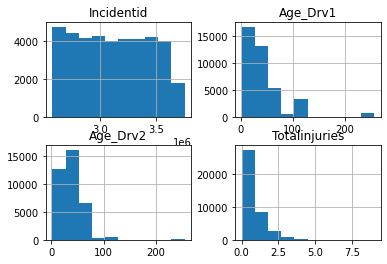

In [80]:
#grouped for non fatal accidents drivers information
q4 = """SELECT IncidentID,
        Age_Drv1, Gender_Drv1,Violation1_Drv1, AlcoholUse_Drv1,
        DrugUse_Drv1, Age_Drv2, Gender_Drv2, Violation1_Drv2,
        AlcoholUse_Drv2, DrugUse_Drv2, Injuryseverity ,Totalinjuries
        FROM nonfatal_frame"""

non_fatal_drv_info = sqldf(q4,globals())

#detecting outliers
sqldf("SELECT Age_Drv1, Age_Drv2 FROM non_fatal_drv_info WHERE Age_Drv1 > 100 OR Age_Drv2 > 100")
non_fatal_drv_info.hist()

array([[<AxesSubplot:title={'center':'Incidentid'}>,
        <AxesSubplot:title={'center':'Age_Drv1'}>],
       [<AxesSubplot:title={'center':'Age_Drv2'}>,
        <AxesSubplot:title={'center':'Totalinjuries'}>]], dtype=object)

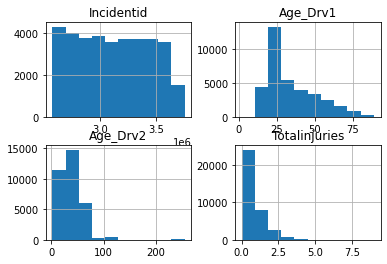

In [81]:
#cleaning our dataframe using quartiles
Q1_Drv1 = non_fatal_drv_info['Age_Drv1' and 'Age_Drv2'].quantile(0.25)
Q3_Drv1 = non_fatal_drv_info['Age_Drv1' and 'Age_Drv2'].quantile(0.75)
IQR1 = Q3_Drv1 - Q1_Drv1

lower_lim_Drv1 = Q1_Drv1 - (1.5 * IQR1)
upper_lim_Drv1 = Q3_Drv1 + (1.5 * IQR1)

outliers_Drv1_low = (non_fatal_drv_info['Age_Drv1' or 'Age_Drv2'] < lower_lim_Drv1)
outliers_Drv2_low = (non_fatal_drv_info['Age_Drv1' or 'Age_Drv2'] > upper_lim_Drv1)


non_fatal_drv_info = non_fatal_drv_info[~(outliers_Drv1_low | outliers_Drv2_low)]

#clean dataset
non_fatal_drv_info.hist()

In [82]:
#time + location fatal
q5 = """SELECT IncidentID, Year, DateTime, StreetName, CrossStreet, Latitude, Longitude,
        Lightcondition, Weather, SurfaceCondition
        FROM fatal_frame;
        """
time_location_fatal = sqldf(q5,globals())

time_location_fatal.describe()

,Incidentid,Year,Latitude,Longitude
count,9.900000e+01,99.000000,99.000000,99.000000
mean,3.220083e+06,2016.535354,33.399627,-111.930771
std,3.101645e+05,2.296018,0.027665,0.027462
min,2.589984e+06,2012.000000,33.334548,-111.978338
25%,2.909490e+06,2014.000000,33.378445,-111.952571
50%,3.263628e+06,2017.000000,33.400049,-111.928500
75%,3.470776e+06,2018.000000,33.417612,-111.907317
max,3.720566e+06,2020.000000,33.454875,-111.877852


array([[<AxesSubplot:title={'center':'Year'}>]], dtype=object)

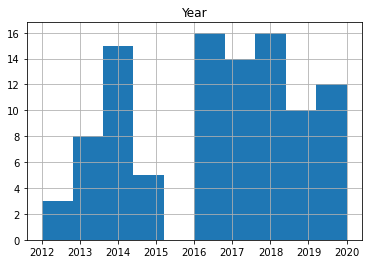

In [83]:
#exploring our data
time_location_fatal.hist('Year')

In [84]:
# time + location nonfatal
q6 = """SELECT IncidentID, Year, DateTime, StreetName, CrossStreet, Latitude, Longitude,
        Lightcondition, Weather, SurfaceCondition
        FROM nonfatal_frame;
        """
time_location_non_fatal = sqldf(q6, globals())
time_location_non_fatal.describe()

,Incidentid,Year,Latitude,Longitude
count,3.981800e+04,39818.000000,39680.000000,39680.000000
mean,3.121640e+06,2015.920212,33.397689,-111.932550
std,3.220607e+05,2.445578,0.028702,0.024174
min,2.579417e+06,2012.000000,33.319857,-111.978469
25%,2.835613e+06,2014.000000,33.378258,-111.952180
50%,3.111136e+06,2016.000000,33.407268,-111.928600
75%,3.400123e+06,2018.000000,33.421929,-111.911207
max,3.750445e+06,2020.000000,33.458484,-111.877419


array([[<AxesSubplot:title={'center':'Incidentid'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Latitude'}>,
        <AxesSubplot:title={'center':'Longitude'}>]], dtype=object)

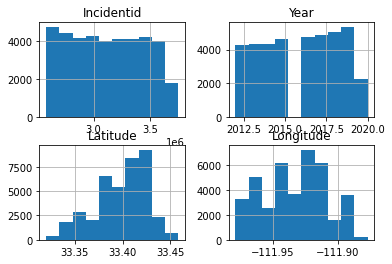

In [85]:
time_location_non_fatal.hist()

## Basic Statistical Tests

In [86]:
#pearsons correlation coefficient non fatal 
non_fatal_drv_info.corr(method='pearson')

,Incidentid,Age_Drv1,Age_Drv2,Totalinjuries
Incidentid,1.000000,0.023055,0.009846,0.048741
Age_Drv1,0.023055,1.000000,0.035705,-0.003930
Age_Drv2,0.009846,0.035705,1.000000,-0.016538
Totalinjuries,0.048741,-0.003930,-0.016538,1.000000


In [87]:
#pearsons correlation coefficient fatal
fatal_drv_info.corr(method='pearson')

,Incidentid,Age_Drv1,Age_Drv2,Totalfatalities,Totalinjuries
Incidentid,1.000000,0.123256,0.105327,-0.007811,-0.040614
Age_Drv1,0.123256,1.000000,-0.086399,-0.025647,-0.073642
Age_Drv2,0.105327,-0.086399,1.000000,0.024508,0.190016
Totalfatalities,-0.007811,-0.025647,0.024508,1.000000,0.111594
Totalinjuries,-0.040614,-0.073642,0.190016,0.111594,1.000000


In [88]:
#pearsons correlation coefficient time location fatal
time_location_fatal.corr(method='pearson')

,Incidentid,Year,Latitude,Longitude
Incidentid,1.000000,0.992152,-0.092034,0.009606
Year,0.992152,1.000000,-0.092409,0.019367
Latitude,-0.092034,-0.092409,1.000000,0.055941
Longitude,0.009606,0.019367,0.055941,1.000000


In [89]:
#pearsons correlation coefficient time location fatal
time_location_non_fatal.corr(method='pearson')

,Incidentid,Year,Latitude,Longitude
Incidentid,1.000000,0.991608,0.017566,-0.021917
Year,0.991608,1.000000,0.017171,-0.022581
Latitude,0.017566,0.017171,1.000000,0.151254
Longitude,-0.021917,-0.022581,0.151254,1.000000


In [90]:
#simple regression models show that we cannot show a strong realtionship between age and injury rate
non_fatal_drv_info = non_fatal_drv_info.fillna(value=0)
X = non_fatal_drv_info[['Age_Drv1', 'Age_Drv2']]
Y = non_fatal_drv_info[['Totalinjuries']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model_summary = model.summary()
print(model_summary)

                            OLS Regression Results                            
Dep. Variable:          Totalinjuries   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8227
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.439
Time:                        11:55:56   Log-Likelihood:                -43688.
No. Observations:               35729   AIC:                         8.738e+04
Df Residuals:                   35726   BIC:                         8.741e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4739      0.012     39.098      0.0